## Towards a generic transpilation approach for quantum circuits through re-synthesis
### A PauliOpt demo


Arianne Meijer - van de Griend

University of Helsinki

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository.

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: /home/tung/Desktop/Master/Helsinki/pauliopt


General imports

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
#set_matplotlib_formats('svg')
import numpy as np
from qiskit.circuit.library import Permutation

draw_kwargs = {"output": "mpl", "scale":.3}

def draw_circuit(circuit, *args, **kwargs):
    qc = circuit.to_qiskit(*args, **kwargs)
    if qc.metadata:
        if "initial_layout" in qc.metadata:
            init_mapping = qc.metadata["initial_layout"]
            qc.compose(Permutation(qc.num_qubits, init_mapping), front=True, inplace=True)
        if "final_layout" in qc.metadata:
            final_mapping = qc.metadata["final_layout"]
            qc.compose(Permutation(qc.num_qubits, final_mapping), front=False, inplace=True)
    print("Number of CNOTs:", qc.count_ops()["cx"])
    return qc.draw(**draw_kwargs)

## Quantum circuit compilation

Suppose we want to run the circuit
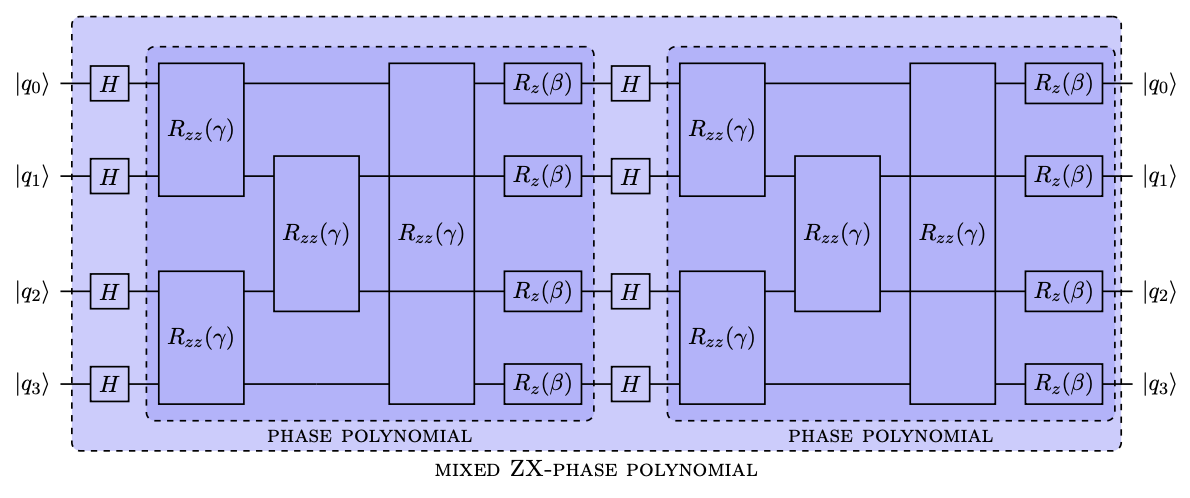

on a quantum computer with qubit connectivity 
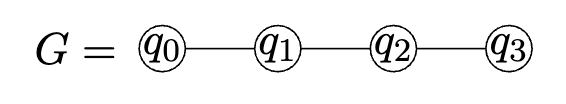

In [3]:
from pauliopt.topologies import Topology

n_qubits = 4
no_topology = Topology.complete(n_qubits)
topology = Topology.line(n_qubits)

Number of CNOTs: 16


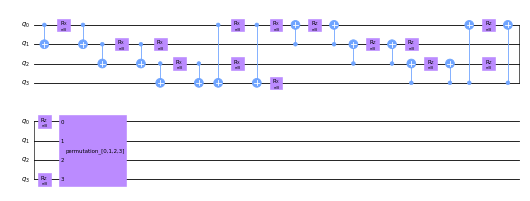

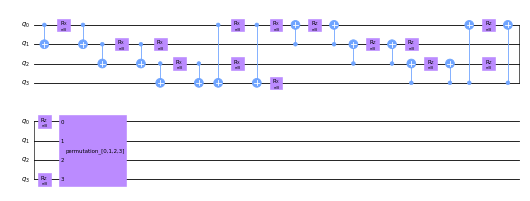

In [4]:
from pauliopt.phase import PhaseCircuit, PhaseGadget
from pauliopt.utils import pi

g = [(0,1), (1,2), (2,3), (3,0), (0,), (1,), (2,), (3,)]
angle = pi/8
gadgets = [PhaseGadget("X", angle, qubits) for qubits in g] \
        + [PhaseGadget("Z", angle, qubits) for qubits in g] 
example = PhaseCircuit(n_qubits, gadgets)
draw_circuit(example, no_topology)

## Intermediate representation
We can write this circuit as phase gadgets in ZX
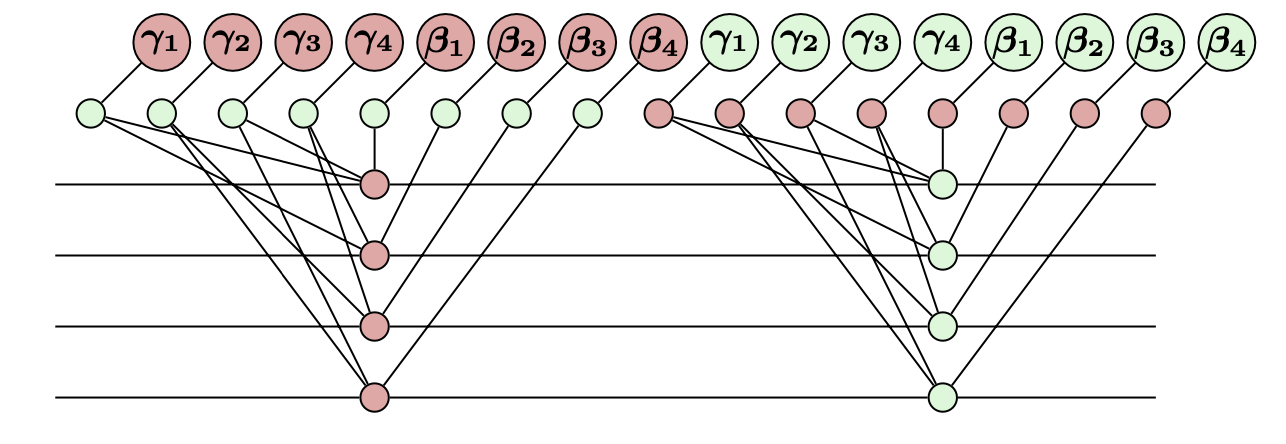

Which we can describe using binary matrices (Mixed ZX-phase polynomial \[1\])
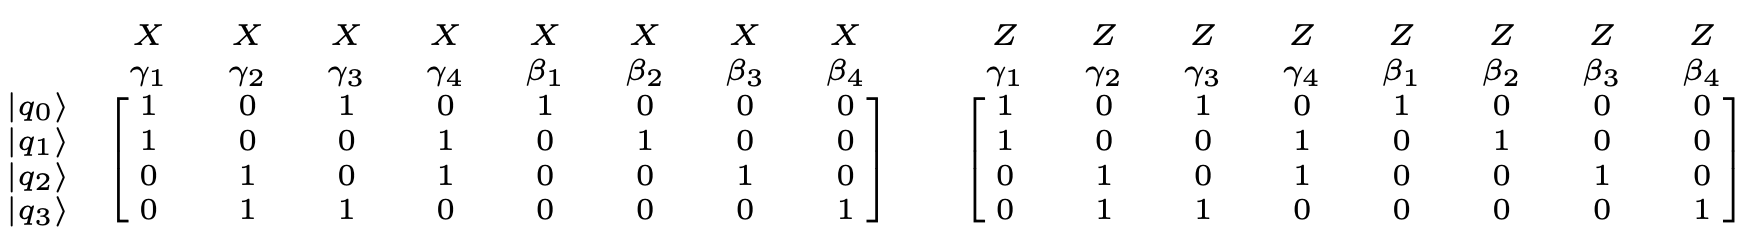

\[1\] https://www.qplconference.org/proceedings2022/QPL_2022_paper_133.pdf


## PauliOpt synthesis
Originally only naive synthesis.
Now with the addition of Steiner-GraySynth \[2\], ParitySynth \[3\], and PermRowCol \[4\].

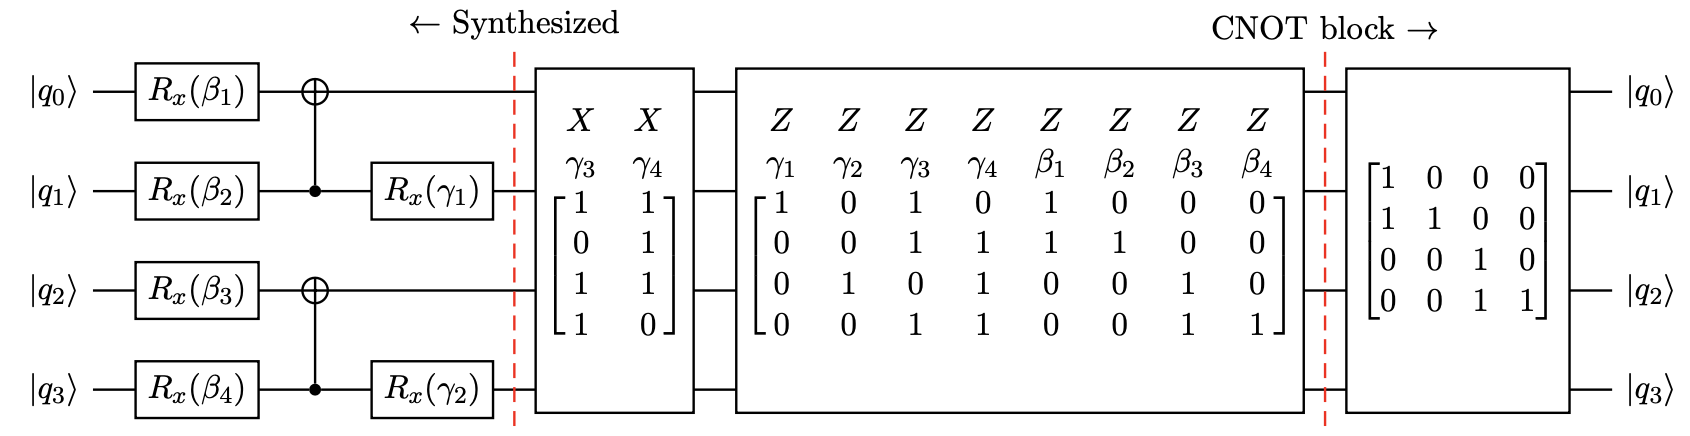

\[2\] https://arxiv.org/pdf/2004.06052.pdf (QPL2020)

\[3\] Vandaele, V., Martiel, S., & de Brugière, T. G. (2022). Phase polynomials synthesis algorithms for NISQ architectures and beyond. Quantum Science and Technology, 7(4), 045027.

\[4\] https://www.qplconference.org/proceedings2022/QPL_2022_paper_99.pdf

## Example usages

Number of CNOTs: 32


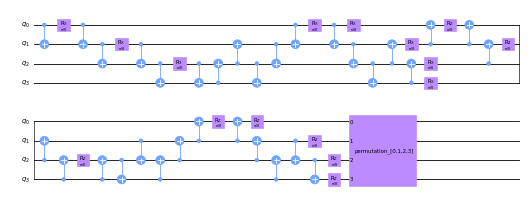

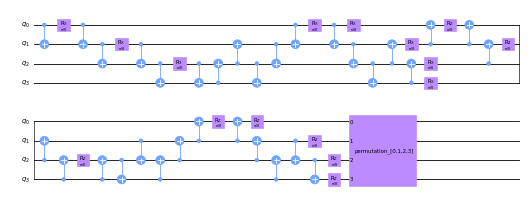

In [5]:
draw_circuit(example, topology, method="naive")

Number of CNOTs: 32


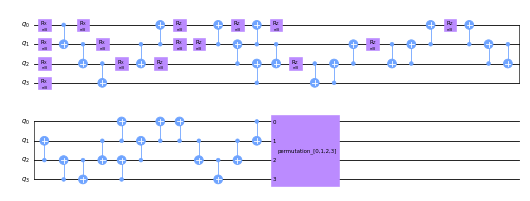

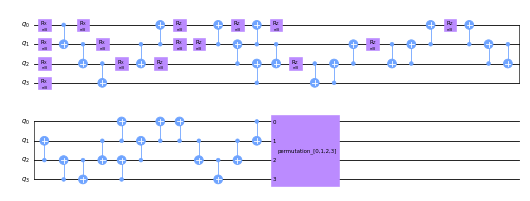

In [6]:
draw_circuit(example, topology, method="paritysynth", \
                  cx_synth="naive")

Number of CNOTs: 32


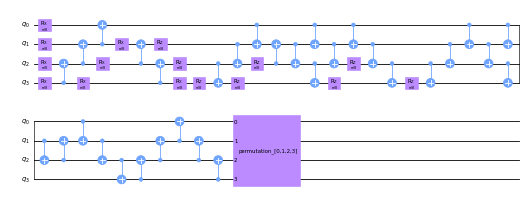

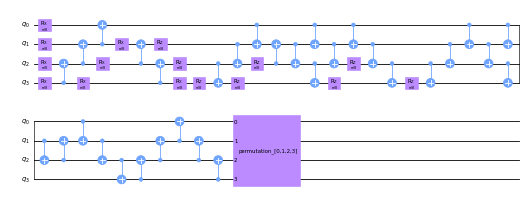

In [7]:
draw_circuit(example, topology, method="steiner-graysynth", \
                  cx_synth="naive")

/home/tung/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Number of CNOTs: 28


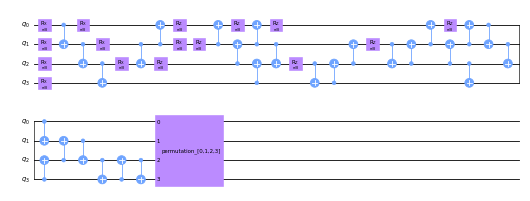

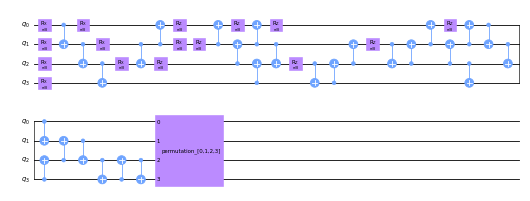

In [8]:
draw_circuit(example, topology, method="paritysynth", \
                  cx_synth="permrowcol", reallocate=False)

Number of CNOTs: 24


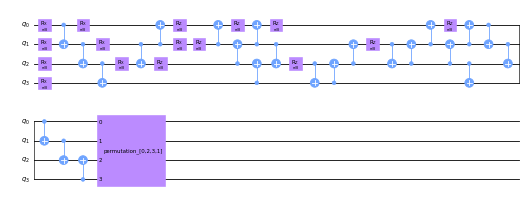

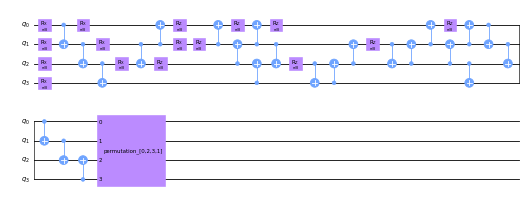

In [9]:
draw_circuit(example, topology, method="paritysynth", \
                  cx_synth="permrowcol", reallocate=True) 

Number of CNOTs: 21


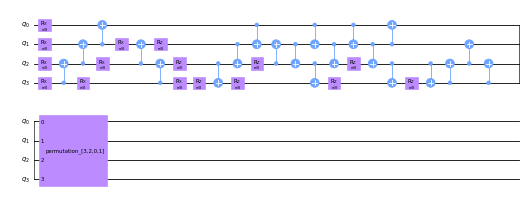

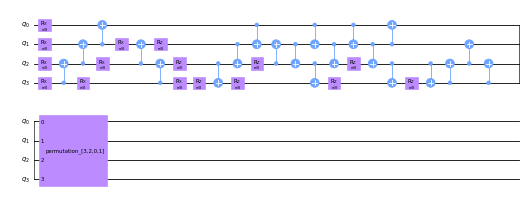

In [10]:
draw_circuit(example, topology, method="steiner-graysynth", \
                  cx_synth="permrowcol", reallocate=True)

## Simulated annealing
Find CNOTs to add the the circuit before synthesis to simplify synthesis

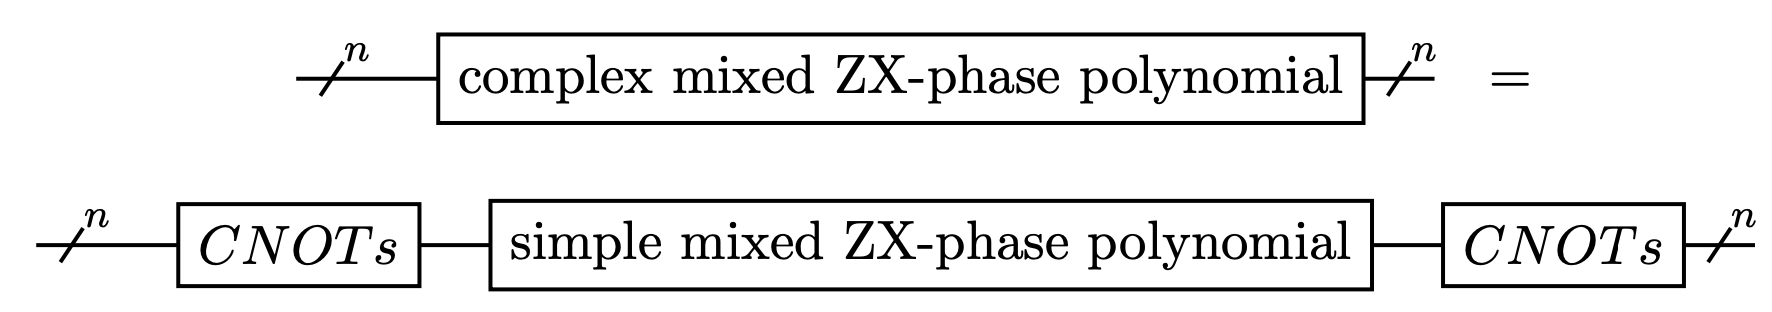


Number of CNOTs: 23


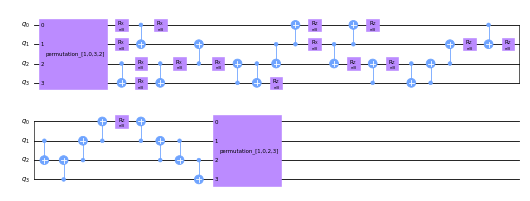

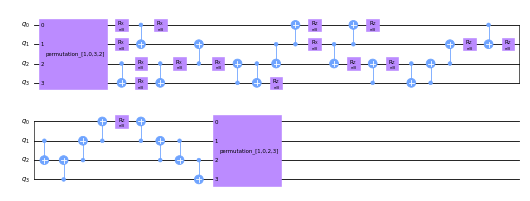

In [11]:
from pauliopt.phase import OptimizedPhaseCircuit

n_iter, cx_block = 1000, 3
opt = OptimizedPhaseCircuit(example.copy(), topology, cx_block,\
    phase_method="paritysynth", cx_method="permrowcol",reallocate=True)
opt.anneal(n_iter)
draw_circuit(opt)

Number of CNOTs: 18


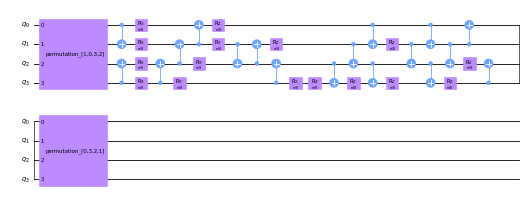

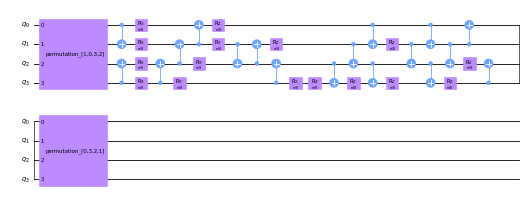

In [12]:
opt = OptimizedPhaseCircuit(example, topology, cx_block,\
    phase_method="steiner-graysynth", cx_method="permrowcol",reallocate=True)
opt.anneal(n_iter)
draw_circuit(opt)

## Reverse traversal
Iteratively improve both intial and output qubit mapping

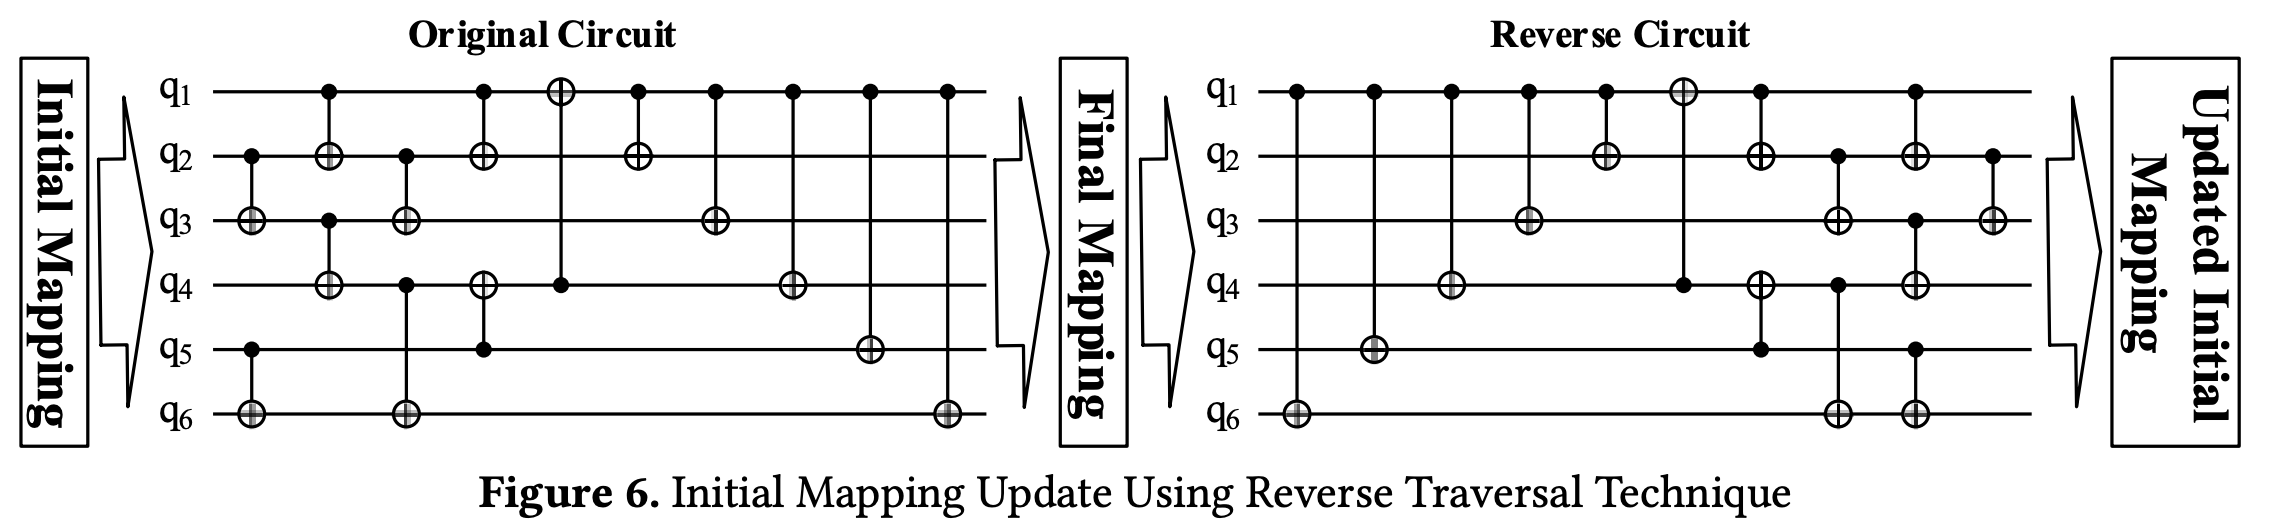

Picture from \[5\].

\[5\] Li, G., Ding, Y., & Xie, Y. (2019, April). Tackling the qubit mapping problem for NISQ-era quantum devices. In Proceedings of the Twenty-Fourth International Conference on Architectural Support for Programming Languages and Operating Systems (pp. 1001-1014).


Qubit numbering: range(0, 4)
Number of CNOTs: 24


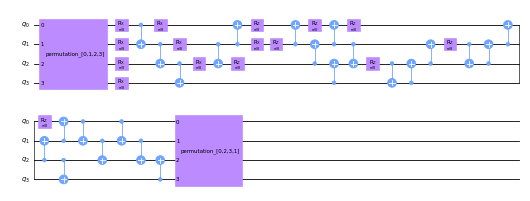

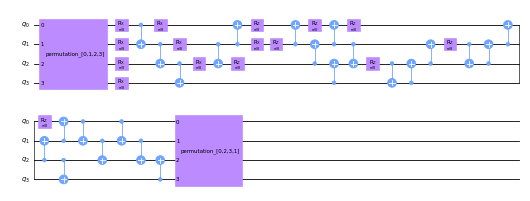

In [13]:
from pauliopt.phase import reverse_traversal

rt_iter = 10
opt_kwargs = {
    "phase_method": "paritysynth",
    "cx_method": "permrowcol",
    "reallocate": True
}
opt = reverse_traversal(example, topology, cx_block,\
                        rt_iter, 0, opt_kwargs)
print("Qubit numbering:", opt._qubit_mapping)
draw_circuit(opt)

Qubit numbering: range(0, 4)
Number of CNOTs: 23


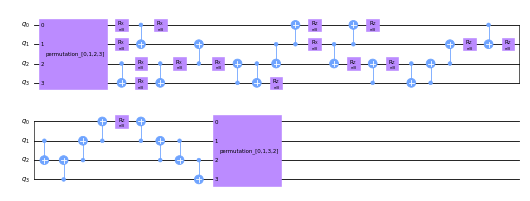

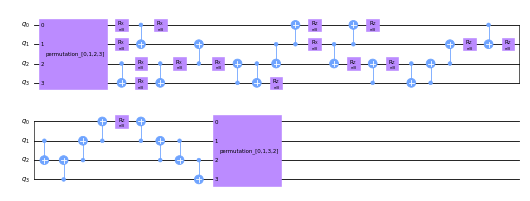

In [14]:
opt = reverse_traversal(example, topology, cx_block,\
                        rt_iter, n_iter, opt_kwargs)
print("Qubit numbering:", opt._qubit_mapping)
draw_circuit(opt)

Qubit numbering: [1, 0, 2, 3]
Number of CNOTs: 21


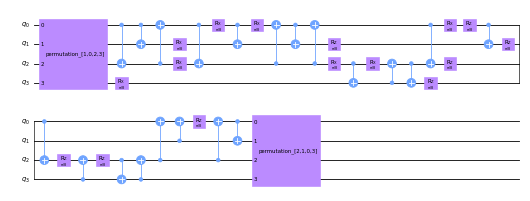

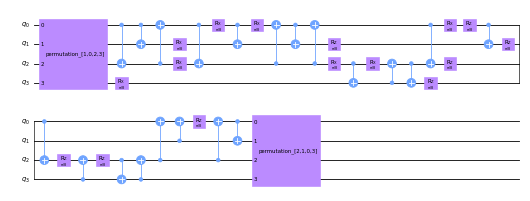

In [15]:
from pauliopt.phase import reverse_traversal_anneal

opt = reverse_traversal_anneal(example, topology, cx_block,\
                                rt_iter, n_iter, opt_kwargs)
print("Qubit numbering:", opt._qubit_mapping)
draw_circuit(opt)

Qubit numbering: range(0, 4)
Number of CNOTs: 21


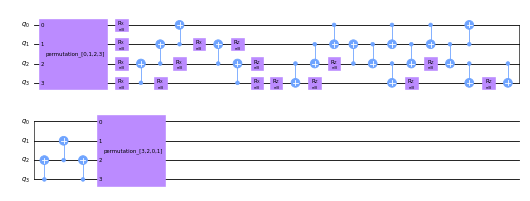

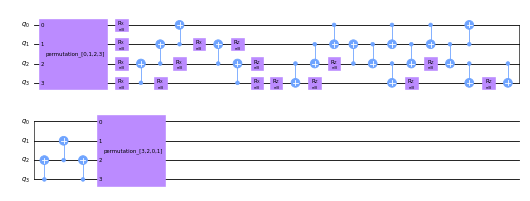

In [16]:
opt_kwargs["phase_method"] = "steiner-graysynth"
opt = reverse_traversal(example, topology, cx_block,\
                        rt_iter, 0, opt_kwargs)
print("Qubit numbering:", opt._qubit_mapping)
draw_circuit(opt)

Qubit numbering: range(0, 4)
Number of CNOTs: 18


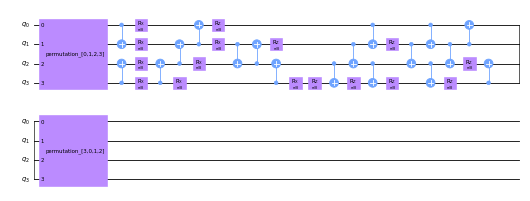

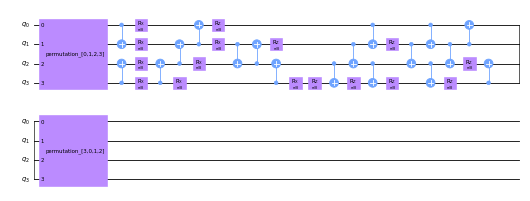

In [17]:
opt = reverse_traversal(example, topology, cx_block,\
                        rt_iter, n_iter, opt_kwargs)
print("Qubit numbering:", opt._qubit_mapping)
draw_circuit(opt)

Qubit numbering: [3, 0, 1, 2]
Number of CNOTs: 16


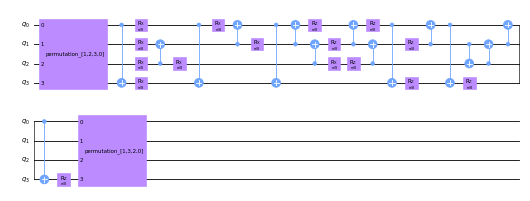

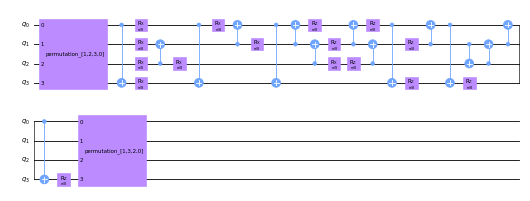

In [18]:
opt = reverse_traversal_anneal(example, topology, cx_block,\
                                rt_iter, n_iter, opt_kwargs)
print("Qubit numbering:", opt._qubit_mapping)
draw_circuit(opt)

## Current WiP
- [x] Fix permutation recovery problems
- [x] Extend phase gadgets to Pauli gadgets
- [ ] Generalize synthesis to Pauli gadgets
     - Push Cliffords in stead of CNOTs
     - Similar to Wednessday's talk on Pauli rotations
- [x] Add architecture constrained Clifford synthesis

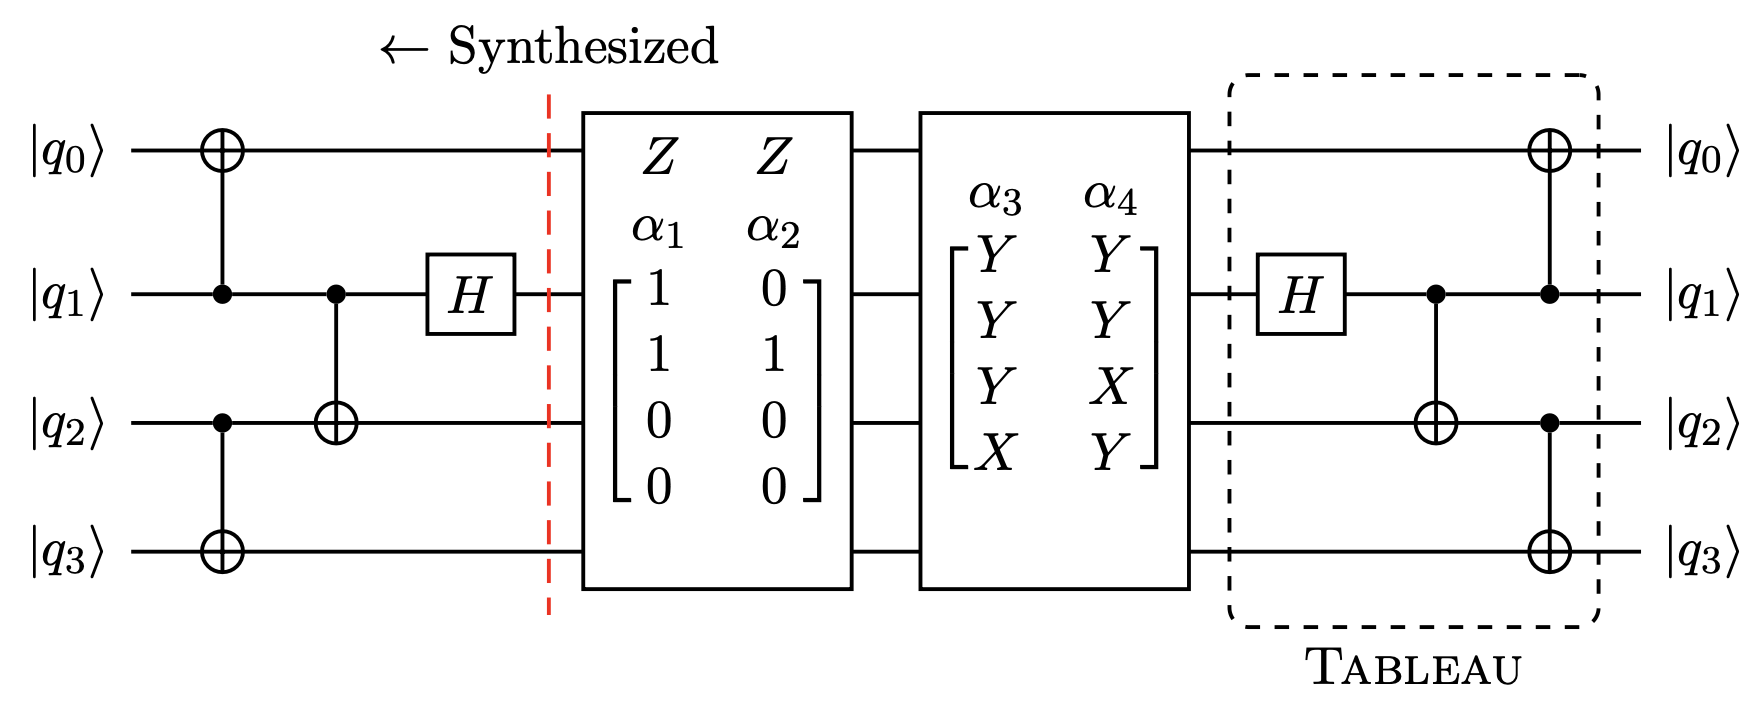

## Call to action

Code is open source and available on
### https://github.com/sg495/pauliopt

Please use, improve, and leave feedback.

Paper: https://arxiv.org/pdf/2304.08814.pdf
Note that the results in v1 of the paper are incorrect due to a bug that has since been fixed.